In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
path = '/content/drive/MyDrive/FYPDATA/'

In [13]:
import pandas as pd

train_df = pd.read_csv(path + "train_fyp_3.csv",low_memory=False)
test_df = pd.read_csv(path + "test_fyp_3.csv",low_memory=False)

In [169]:
# train_df = train.iloc[:int(0.3 * len(train))].copy()
# test_df = test.iloc[:int(0.3 * len(test))].copy()

In [215]:
train_df.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,year,family,class,perishable,dcoilwtico,...,dcoilwtico_rolling7,dcoilwtico_rolling30,day_sin,day_cos,week_sin,week_cos,weekday_sin,weekday_cos,month_sin,month_cos
0,2013-04-05,1,96995,-0.236095,0,2013,GROCERY I,1093,0,1.038247,...,1.038257,1.038255,0.866025,0.500000,0.491597,-0.870823,-0.433884,-0.900969,0.866025,-0.500000
1,2013-04-23,1,96995,-1.273443,0,2013,GROCERY I,1093,0,0.897374,...,0.897383,0.897380,-0.994522,0.104528,-0.120126,0.992759,0.781831,0.623490,0.866025,-0.500000
2,2013-05-08,1,96995,-0.488720,0,2013,GROCERY I,1093,0,1.176343,...,1.176353,1.176352,0.998717,-0.050649,0.667691,0.744438,0.974928,-0.222521,0.500000,-0.866025
3,2013-05-10,1,96995,-1.273443,0,2013,GROCERY I,1093,0,1.159279,...,1.159290,1.159288,0.897805,-0.440394,0.582205,-0.813042,-0.433884,-0.900969,0.500000,-0.866025
4,2013-07-11,1,96995,-1.273443,0,2013,GROCERY I,1093,0,1.514835,...,1.514848,1.514848,0.790776,-0.612106,0.990397,0.138250,0.433884,-0.900969,-0.500000,-0.866025


In [14]:
numerical_columns = [
    'Min Temperature (C)', 'Max Temperature (C)', 'dcoilwtico',
    'unit_sales', 'unit_sales_lag1', 'unit_sales_lag7',
    'unit_sales_rolling7', 'unit_sales_rolling30',
    'dcoilwtico_lag1', 'dcoilwtico_rolling7', 'dcoilwtico_rolling30',
    'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos',
    'day_sin', 'day_cos', 'week_sin', 'week_cos','year','date'
]
categorical_columns = [col for col in train_df.columns if col not in numerical_columns]
for col in ['unit_sales', 'year', 'date']:
    if col in numerical_columns:
        numerical_columns.remove(col)

In [15]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    encoders[col] = le

    # Create a mapping from label to index
    class_to_index = {label: idx for idx, label in enumerate(le.classes_)}
    unknown_index = len(le.classes_)

    # Map test data using known classes, assign unseen ones to unknown_index
    test_df[col] = test_df[col].astype(str).map(class_to_index).fillna(unknown_index).astype(int)

In [218]:
import joblib
joblib.dump(encoders,path + 'label_encoder.pkl')

['/content/drive/MyDrive/FYPDATA/label_encoder.pkl']

In [219]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np

class TimeSeriesDataset(Dataset):
  def __init__(self,df,sequence_length,forecast_horizon,categorical_columns,numerical_columns):
    self.data = df
    self.sequence_length = sequence_length
    self.forecast_horizon = forecast_horizon

    self.categorical_features = self.data[categorical_columns].values.astype(np.int64)
    self.numerical_features = self.data[numerical_columns].values.astype(np.float32)
    self.target = self.data['unit_sales'].values.astype(np.float32)

  def __len__(self):
    return len(self.numerical_features) - self.sequence_length - self.forecast_horizon

  def __getitem__(self, index):
    X_num = self.numerical_features[index:index + self.sequence_length]
    X_cat = self.categorical_features[index:index + self.sequence_length]
    # X_cat = np.where(X_cat == -1,encoder.categories_[i].shape[0],X_cat)

    y = self.target[index + self.sequence_length : index + self.sequence_length + self.forecast_horizon]

    return (
        torch.tensor(X_cat,dtype=torch.long),
        torch.tensor(X_num,dtype=torch.float),
        torch.tensor(y,dtype=torch.float)
    )

In [17]:
train_dataset = TimeSeriesDataset(df=train_df,
                            categorical_columns=categorical_columns,
                            numerical_columns=numerical_columns,
                            sequence_length=60,
                            forecast_horizon=7)
test_dataset = TimeSeriesDataset(df=test_df,
                            categorical_columns=categorical_columns,
                            numerical_columns=numerical_columns,
                            sequence_length=60,
                            forecast_horizon=7)

In [222]:
X_cat, X_num, y = train_dataset[0]
print("X_cat:", X_cat.shape)
print("X_num:", X_num.shape)
print("y:", y)
# print(X_num)

X_cat: torch.Size([60, 10])
X_num: torch.Size([60, 18])
y: tensor([ 0.1448,  0.7550, -0.4887, -1.2734, -0.8144, -0.4887, -0.4887])


In [18]:
train_dataloader = DataLoader(train_dataset,batch_size=64,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=64,shuffle=False)

In [224]:
# next(iter(train_dataloader))
X_cat,X_num,y_true = next(iter(train_dataloader))

# print("Sample input:", X_cat[0], X_num[0])
print("Corresponding target:", y_true[0])

Corresponding target: tensor([ 0.1448,  0.7550, -0.4887, -1.2734, -0.8144, -0.4887, -0.4887])


In [225]:
len(train_dataloader),len(test_dataloader)

(37499, 9374)

In [226]:
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:, :x.size(1), :]
        return x

In [227]:
class AttentionPooling(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.attn = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [batch, seq_len, d_model]
        attn_weights = torch.softmax(self.attn(x).squeeze(-1), dim=-1)
        return torch.sum(x * attn_weights.unsqueeze(-1), dim=1)

In [228]:
import torch.nn as nn
import math

class TimeSeriesTransformer(nn.Module):
  def __init__(self, num_numerical_features,categorical_sizes,embedding_sizes,seq_len,forecast_horizon,d_model=256,nhead=4,num_layers=2,dropout=0.1):
    super(TimeSeriesTransformer,self).__init__()

    adjusted_categorical_sizes = [size + 1 for size in categorical_sizes]

    self.embeddings = nn.ModuleList([
        nn.Embedding(num_categories,embedding_dim) for num_categories,embedding_dim in zip(adjusted_categorical_sizes,embedding_sizes)
        # nn.Embedding(num_categories,embedding_dim) for num_categories in categorical_sizes
    ])

    total_embedding_dim = sum(embedding_sizes)
    print(total_embedding_dim)

    self.num_linear = nn.Linear(num_numerical_features,d_model - total_embedding_dim)
    self.pos_encoder = PositionalEncoding(d_model,max_len=seq_len) # change 1
    self.attention_pool = AttentionPooling(d_model) # change 3
    self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model,nhead=nhead,dropout=dropout,batch_first=True)
    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer,num_layers=num_layers)
    self.d_model = d_model
    self.fc_out = nn.Linear(d_model,forecast_horizon)
    # self.pooler = nn.Linear(d_model, d_model) #change 2

  def forward(self,X_cat,X_num):
    embedded_cats = [embed(X_cat[:,:,i]) for i,embed in enumerate(self.embeddings)]
    embedded_cats = torch.cat(embedded_cats,dim=-1)

    X_num = self.num_linear(X_num)

    X_combined = torch.cat([X_num,embedded_cats],dim=-1)

    X_combined = X_combined * math.sqrt(self.d_model)

    X_combined = self.pos_encoder(X_combined) # change 1

    X_encoded = self.transformer_encoder(X_combined)

    # output = self.fc_out(X_encoded[:,-1,:])
    # attention pooling or self pooling using mean
    # output = self.fc_out(self.pooler(X_encoded.mean(dim=1))) #change 2
    output = self.fc_out(self.attention_pool(X_encoded)) #change 3
    return output

In [7]:
num_numerical_features = len(numerical_columns)
categorical_sizes = [len(encoders[col].classes_) + 1 for col in categorical_columns]
embedding_sizes = [min(50, size // 2) for size in categorical_sizes]
seq_len = 60
forecast_horizon = 7

In [10]:
print(num_numerical_features),print(categorical_sizes),print(embedding_sizes),print(seq_len),print(len(categorical_columns))

18
[16, 4013, 3, 34, 332, 3, 7, 77, 5, 11]
[8, 50, 1, 17, 50, 1, 3, 38, 2, 5]
60
10


(None, None, None, None, None)

In [230]:
model = TimeSeriesTransformer(num_numerical_features=num_numerical_features,
                              categorical_sizes=categorical_sizes,
                              embedding_sizes=embedding_sizes,
                              # embedding_dim=64,
                              seq_len=seq_len,
                              forecast_horizon=forecast_horizon).to(device)

175


In [232]:
checkpoint = torch.load(path + '/Checkpoints/model_checkpoint2_old.pth',weights_only=True)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [233]:
with torch.inference_mode():
    sample = next(iter(test_dataloader))
    sample = tuple(x.to(device) for x in sample)  # Move each tensor in the tuple to device
    output = model(*sample[:-1])
    print("Untrained output range:", output.min().item(), output.max().item())

Untrained output range: 0.37509286403656006 1.4232442378997803


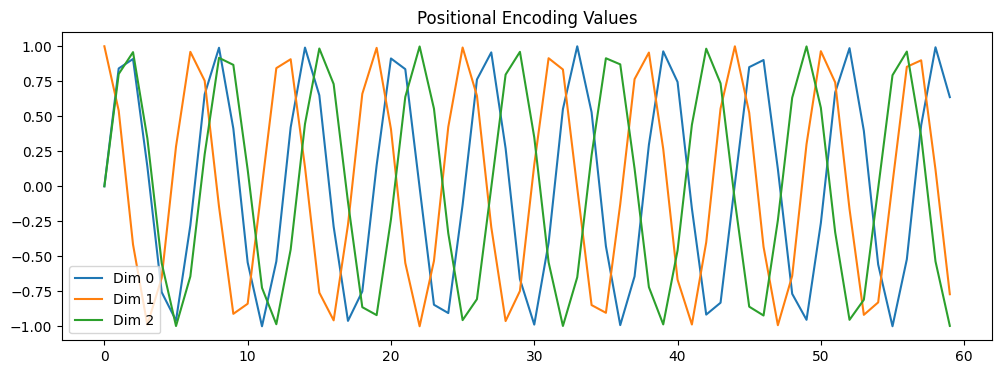

In [234]:
import matplotlib.pyplot as plt

# After initializing your model
pe = model.pos_encoder.pe.squeeze(0).cpu()  # Move to CPU

# Plot first 3 dimensions across time
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.plot(pe[:100, i], label=f"Dim {i}")
plt.title("Positional Encoding Values")
plt.legend()
plt.show()

In [235]:
# next(iter(train_dataloader))
X_cat_sample,X_num_sample,y_sample = next(iter(train_dataloader))
X_cat_sample.shape,X_num_sample.shape,y_sample.shape

(torch.Size([64, 60, 10]), torch.Size([64, 60, 18]), torch.Size([64, 7]))

In [236]:
output = model(X_cat_sample.to(device),X_num_sample.to(device))
output.shape

torch.Size([64, 7])

In [237]:
X_cat_sample,X_num_sample,y_sample = next(iter(train_dataloader))
X_cat_sample.shape,X_num_sample.shape,y_sample.shape

(torch.Size([64, 60, 10]), torch.Size([64, 60, 18]), torch.Size([64, 7]))

In [238]:
print(torch.isnan(X_num_sample).sum(), torch.isinf(X_num_sample).sum())  # Should be 0
print(torch.isnan(X_cat_sample).sum(), torch.isinf(X_cat_sample).sum())  # Should be 0

tensor(0) tensor(0)
tensor(0) tensor(0)


In [239]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

In [240]:
from timeit import default_timer as timer

def print_train_time(start:float,end:float,device:torch.device = None):
  total_time = end-start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  # return total_time

In [48]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [241]:
from torchmetrics.regression import MeanSquaredError, MeanAbsoluteError, R2Score
from tqdm import tqdm
import torch
import torch.nn as nn

def train_step(model: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               device: torch.device,
               dataloader: torch.utils.data.DataLoader,
               target_scaler):

    total_samples = 0
    train_loss = 0
    all_preds = []
    all_true = []

    # Initialize metrics
    mse_metric = MeanSquaredError().to(device)
    mae_metric = MeanAbsoluteError().to(device)

    model.train()

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Training', leave=True)

    for batch_idx, batch in progress_bar:
        X_cat, X_num, y_true = batch
        X_cat, X_num, y_true = X_cat.to(device), X_num.to(device), y_true.to(device)

        y_pred = model(X_cat, X_num).squeeze(-1)

        loss = loss_fn(y_pred, y_true)

        all_preds.append(y_pred.detach().cpu())
        all_true.append(y_true.detach().cpu())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss tracking
        batch_size = y_true.size(0)
        train_loss += loss.item() * batch_size
        total_samples += batch_size

        if (batch_idx+1) % 7000 == 0:
            print(f"Looked at {batch_idx * len(X_cat)}/{len(dataloader.dataset)} samples.")

    # Convert to numpy arrays
    all_preds = torch.cat(all_preds).numpy()
    all_true = torch.cat(all_true).numpy()

    # Inverse transform if scaler is provided
    if target_scaler is not None:
        all_preds = np.expm1(target_scaler.inverse_transform(all_preds.reshape(-1, 1))).squeeze()
        all_true = np.expm1(target_scaler.inverse_transform(all_true.reshape(-1, 1))).squeeze()

    # Convert back to tensors on correct device
    all_preds_tensor = torch.tensor(all_preds, device=device)
    all_true_tensor = torch.tensor(all_true, device=device)

    # Calculate metrics
    final_mse = mse_metric(all_preds_tensor, all_true_tensor).item()
    final_mae = mae_metric(all_preds_tensor, all_true_tensor).item()
    avg_loss = train_loss / total_samples  # Scaled loss

    print(f"Train Loss (Scaled): {avg_loss:.5f} | MSE (Unscaled): {final_mse:.5f} | MAE (Unscaled): {final_mae:.5f}")


In [242]:
def test_step(model: nn.Module,
              loss_fn: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              device: torch.device,
              target_scaler):

    test_loss = 0.0
    total_samples = 0
    all_preds = []
    all_true = []

    # Initialize metrics
    mse_metric = MeanSquaredError().to(device)
    mae_metric = MeanAbsoluteError().to(device)
    r2_metric = R2Score().to(device)

    model.eval()

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Testing', leave=True)

    with torch.inference_mode():
        for batch_idx, batch in progress_bar:
            X_cat, X_num, y_true = batch
            X_cat, X_num, y_true = X_cat.to(device), X_num.to(device), y_true.to(device)

            test_pred = model(X_cat, X_num).squeeze(-1)

            # Collect predictions and true values
            all_preds.append(test_pred.detach().cpu())
            all_true.append(y_true.detach().cpu())

            # Calculate loss
            loss = loss_fn(test_pred, y_true)
            test_loss += loss.item() * y_true.size(0)
            total_samples += y_true.size(0)

    # Convert to numpy arrays
    all_preds = torch.cat(all_preds).numpy()
    all_true = torch.cat(all_true).numpy()

    # Inverse transform if scaler is provided
    if target_scaler is not None:
        all_preds = np.expm1(target_scaler.inverse_transform(all_preds.reshape(-1, 1))).squeeze()
        all_true = np.expm1(target_scaler.inverse_transform(all_true.reshape(-1, 1))).squeeze()

    # Convert back to tensors on correct device
    all_preds_tensor = torch.tensor(all_preds, device=device)
    all_true_tensor = torch.tensor(all_true, device=device)

    # Calculate metrics
    mse = mse_metric(all_preds_tensor, all_true_tensor).item()
    mae = mae_metric(all_preds_tensor, all_true_tensor).item()
    r2 = r2_metric(all_preds_tensor, all_true_tensor).item()
    rmse = torch.sqrt(torch.tensor(mse, device=device)).item()
    avg_loss = test_loss / total_samples  # Scaled loss

    print(f"Test Loss (Scaled): {avg_loss:.5f} | MSE: {mse:.5f} | RMSE: {rmse:.5f} | MAE: {mae:.5f} | R2: {r2:.5f}")

In [243]:
# def evaluate_model(model: nn.Module,
#                   loss_fn: nn.Module,
#                   dataloader: torch.utils.data,
#                   device: device):

#   test_loss = 0.0
#   total_mse,total_mae = 0.0,0.0
#   model.eval()

#   progress_bar = tqdm(enumerate(dataloader),total=len(dataloader),desc='Testing',leave=True)

#   with torch.inference_mode():
#     for batch_idx,batch in progress_bar:
#       X_cat,X_num,y_true = batch
#       X_cat,X_num,y_true = X_cat.to(device),X_num.to(device),y_true.to(device)

#       test_pred = model(X_cat,X_num).squeeze()
#       loss = loss_fn(test_pred,y_true)
#       test_loss += loss.item()

#       total_mse += mse(test_pred, y_true).item()
#       total_mae += mae(test_pred, y_true).item()

#   avg_loss = test_loss / len(dataloader)
#   avg_mse = total_mse / len(dataloader)
#   avg_mae = total_mae / len(dataloader)
#   avg_rmse = avg_mse ** 0.5  # RMSE = sqrt(MSE)

#   return {"model_name":model.__class__.__name__,#this only works if model was created by class
#           "model_loss":avg_loss.item(),
#           "model_mse":avg_mse.item(),
#           "model_mae":avg_mae.item(),
#           "model_rmse":avg_rmse.item()}

In [244]:
import joblib

target_scaler = joblib.load(path + 'target_scaler_2.pkl')

In [245]:
import torch

torch.manual_seed(42)
# torch.cuda.manual_seed(42)

train_start = timer()

epochs = 2

for epoch in range(epochs):
  print(f"Epoch: {epoch+1}\n---------------")
  train_step(model=model,
             optimizer=optimizer,
            #  scheduler=scheduler,
             loss_fn=loss_fn,
             device=device,
             dataloader=train_dataloader,
             target_scaler=target_scaler)

  test_step(model=model,
            loss_fn=loss_fn,
            device=device,
            dataloader=test_dataloader,
            target_scaler=target_scaler)

train_end = timer()
print_train_time(train_start,train_end,device)

Epoch: 1
---------------


Training:  19%|█▊        | 7004/37499 [03:14<14:32, 34.94it/s]

Looked at 447936/2399933 samples.


Training:  37%|███▋      | 14004/37499 [06:27<11:09, 35.10it/s]

Looked at 895936/2399933 samples.


Training:  56%|█████▌    | 21004/37499 [09:40<07:27, 36.83it/s]

Looked at 1343936/2399933 samples.


Training:  75%|███████▍  | 28004/37499 [12:57<04:47, 33.03it/s]

Looked at 1791936/2399933 samples.


Training:  93%|█████████▎| 35006/37499 [16:18<01:08, 36.15it/s]

Looked at 2239936/2399933 samples.


Training: 100%|██████████| 37499/37499 [17:28<00:00, 35.76it/s]


Train Loss (Scaled): 0.42982 | MSE (Unscaled): 374.14532 | MAE (Unscaled): 4.53375


Testing: 100%|██████████| 9374/9374 [01:24<00:00, 110.56it/s]


Test Loss (Scaled): 0.49181 | MSE: 323.26306 | RMSE: 17.97952 | MAE: 5.57814 | R2: 0.37606
Epoch: 2
---------------


Training:  19%|█▊        | 7004/37499 [03:14<13:50, 36.73it/s]

Looked at 447936/2399933 samples.


Training:  37%|███▋      | 14004/37499 [06:30<10:42, 36.57it/s]

Looked at 895936/2399933 samples.


Training:  56%|█████▌    | 21005/37499 [09:47<08:05, 34.01it/s]

Looked at 1343936/2399933 samples.


Training:  75%|███████▍  | 28005/37499 [13:03<04:34, 34.61it/s]

Looked at 1791936/2399933 samples.


Training:  93%|█████████▎| 35005/37499 [16:16<01:07, 36.88it/s]

Looked at 2239936/2399933 samples.


Training: 100%|██████████| 37499/37499 [17:26<00:00, 35.84it/s]


Train Loss (Scaled): 0.42269 | MSE (Unscaled): 362.52365 | MAE (Unscaled): 4.46656


Testing: 100%|██████████| 9374/9374 [01:24<00:00, 111.44it/s]


Test Loss (Scaled): 0.48296 | MSE: 307.85452 | RMSE: 17.54578 | MAE: 5.48779 | R2: 0.40580
Train time on cuda: 2266.521 seconds


In [246]:
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred, title='Forecast vs Actual'):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true, label='Actual', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

In [20]:
# Get a test batch
X_cat, X_num, y_true_scaled = next(iter(test_dataloader))
torch.save({
    'X_cat': X_cat,
    'X_num': X_num,
    'y': y_true_scaled
}, "sample_batch.pt")

# # Get predictions (in scaled space)
# model.eval()
# with torch.inference_mode():
#     y_pred_scaled = model(X_cat, X_num).squeeze()


In [248]:
print("Variance of scaled test targets:", y_pred_scaled.var())
# print("Test MSE:", test_mse)  # From your logs

Variance of scaled test targets: tensor(0.0649, device='cuda:0')


In [249]:
y_true = np.expm1(target_scaler.inverse_transform(y_true_scaled[0].cpu().numpy().reshape(-1, 1))).flatten()
y_pred = np.expm1(target_scaler.inverse_transform(y_pred_scaled[0].cpu().numpy().reshape(-1, 1))).flatten()

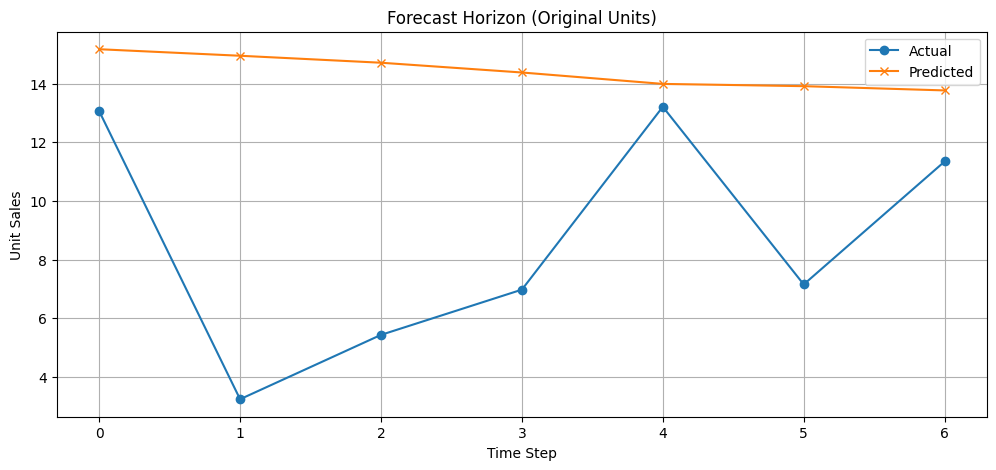

In [250]:
plot_predictions(y_true, y_pred, title="Forecast Horizon (Original Units)")

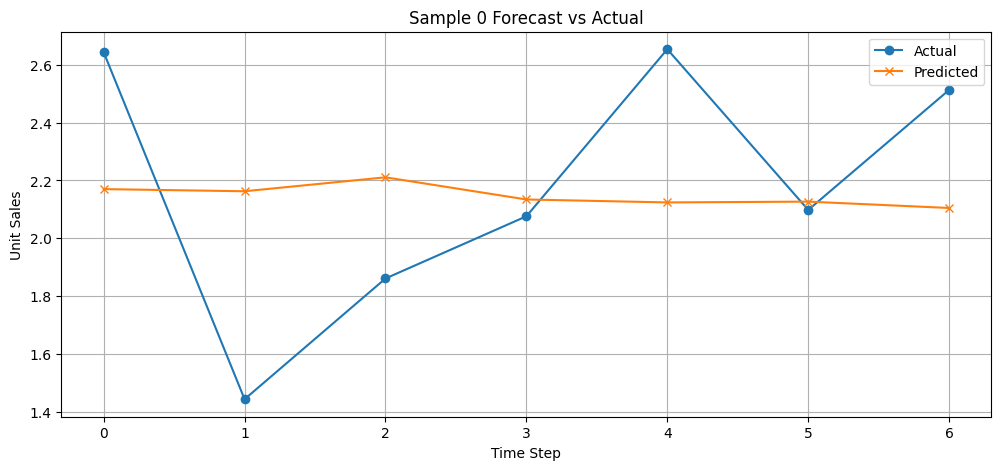

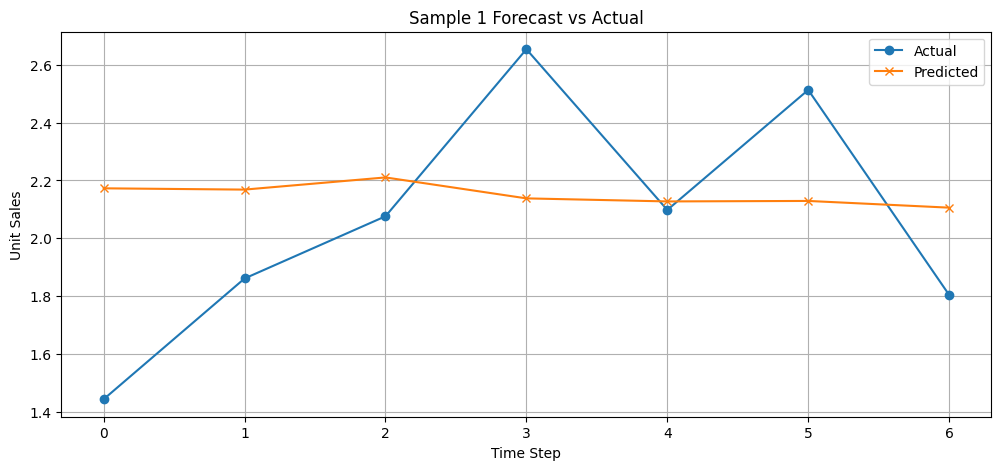

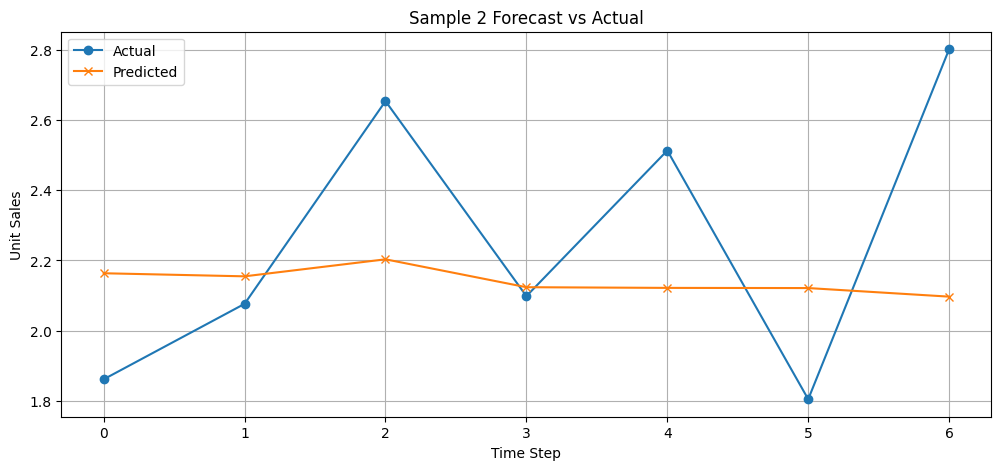

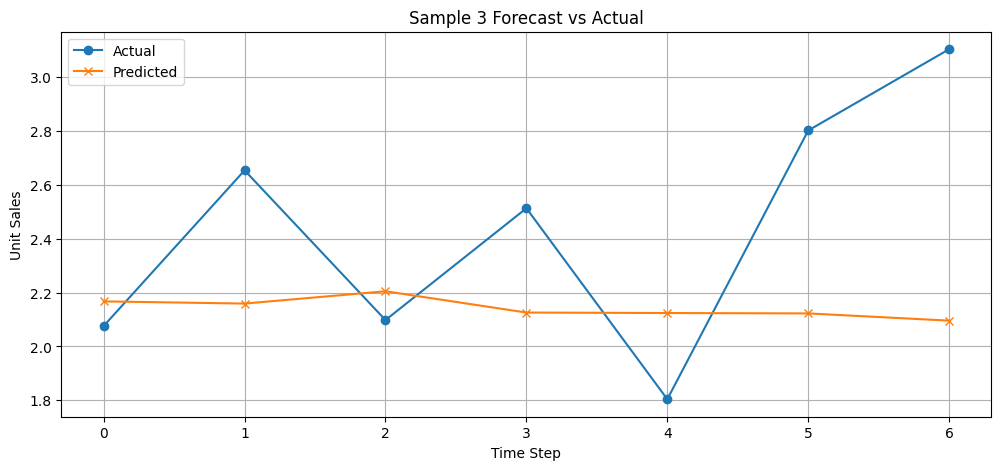

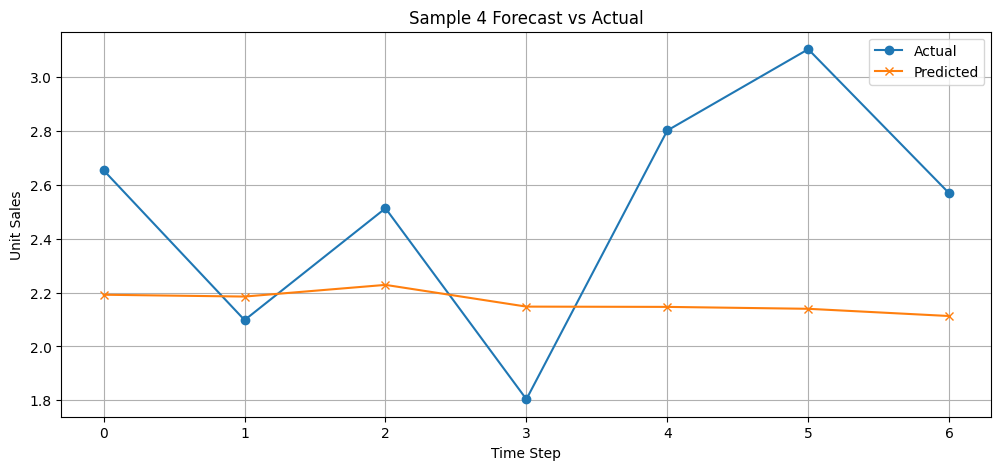

In [212]:
for i in range(min(5, len(y_true_scaled))):  # Plot up to 5 samples
    y_true = target_scaler.inverse_transform(y_true_scaled[i].cpu().numpy().reshape(-1, 1)).flatten()
    y_pred = target_scaler.inverse_transform(y_pred_scaled[i].cpu().numpy().reshape(-1, 1)).flatten()
    plot_predictions(y_true, y_pred, title=f"Sample {i} Forecast vs Actual")

In [181]:
import os

save_path_transformer = path + 'Model/'
save_path_checkpoint = path + 'Checkpoints/'
# Create the directory if it doesn't exist
os.makedirs(save_path_transformer, exist_ok=True)
os.makedirs(save_path_checkpoint, exist_ok=True)


In [182]:
torch.save(model.state_dict(),save_path_checkpoint + "model_checkpoint2_old.pth")
# torch.save(model.state_dict(),save_path_transformer + "model_version.pth")